In [1]:
import os
from typing import List, Dict, Tuple, Any
import time
import json

import numpy as np
from dotenv import load_dotenv
import nrrd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from src.core.utils import fs
from src.flatmap.utils.bridge import *
from src.flatmap.utils.read_ni_output import get_marker_points_from_xml
from src.flatmap.ccf_streamlines.morphology import transform_coordinates_to_volume
from src.flatmap.utils.nb_utils import get_projection_images_from_dict, setup_main_plot, plot_boundaries
from src.flatmap.utils.nb_utils import expand_label_image, dilate_image, dilate_binary_image

from src.flatmap.ccf_streamlines.projection import IsocortexCoordinateProjector
from src.flatmap import external_data_registry as data_registry

In [2]:
if load_dotenv() is False:
    print("Failed to load .env file")

EXPERIMENT_DATA_DIR = os.getenv("CASE_FILE_DATA_DIR")
if EXPERIMENT_DATA_DIR is None:
    print("Failed to load CASE_FILE_DATA_DIR from .env file")

example_case_file_dir = os.path.join(EXPERIMENT_DATA_DIR, "working")
case_files = fs.find_in_dir_with_ext(example_case_file_dir, ".xml")
if len(case_files) == 0:
    print("No case files found in directory")

CASE_FILE_PATH = case_files[0]
ALLEN_DATA_DIR = os.getenv("ALLEN_ATLAS_FILES")

if ALLEN_DATA_DIR is None:
    print("Failed to load ALLEN_ATLAS_FILES from .env file")

ALLEN_ANNOTATION_PATH = os.path.join(ALLEN_DATA_DIR, "annotation_10.nrrd")

if os.path.exists(ALLEN_ANNOTATION_PATH) is False: \
        print(f"Failed to find allen annotation file: {ALLEN_ANNOTATION_PATH}")

In [3]:
print(f"Case file path: {CASE_FILE_PATH}")
print(f"Allen annotation path: {ALLEN_ANNOTATION_PATH}")

Case file path: D:/data/neuro/flatmap/experiments\working\2000_ChAT_rabies 6cases Cortex.xml
Allen annotation path: D:/data/neuro/Allen\annotation_10.nrrd


In [4]:
view_space_for_other_hemisphere = "flatmap_butterfly"
view_lookup_file = "flatmap_butterfly"
    # proj_butterfly_slab = get_isocortex_3d_projector(view_lookup_file=view_lookup_file)
proj_butterfly_slab = get_coordinate_projector(view_lookup_file=view_lookup_file)

In [5]:
bf_left_boundaries, bf_right_boundaries = get_boundaries(view_lookup_file=view_lookup_file,
                                                         view_space_for_other_hemisphere=view_space_for_other_hemisphere)
bf_projection_max = get_average_template_projection()


loading path information


100%|██████████| 1016/1016 [00:06<00:00, 145.71it/s]


KeyError: ('flatmap_butterfly',)

In [7]:
bf_projection_max_3d = get_avg_normalized_layers_butterfly()

flatmap_butterfly
loading path information


100%|██████████| 1016/1016 [00:07<00:00, 143.90it/s]


In [8]:
marker_points = get_marker_points_from_xml(CASE_FILE_PATH)

In [19]:
morphological_list = []
names = marker_points.keys()
factor_values = (-1, -1, 1)
scale: str = "voxels"
thickness_type: str = "unnormalized"
# thickness_type: str = "normalized_full"
# thickness_type: str = "normalized_layers"
hemisphere: str = "both"
view_space_for_other_hemisphere: bool = False,
drop_voxels_outside_view_streamlines: bool = False

for i, points in enumerate(marker_points.values()):
    tic = time.perf_counter()

    points_vals_copy = points.copy()

    points_vals_copy = np.floor(points_vals_copy / factor_values).astype(int)
    points_vals = points_vals_copy.copy()

    morph_layers= proj_butterfly_slab.project_coordinates(
        coords=points_vals,
        scale=scale,
        thickness_type=thickness_type,
        hemisphere = hemisphere,
        view_space_for_other_hemisphere=view_space_for_other_hemisphere,
        drop_voxels_outside_view_streamlines=drop_voxels_outside_view_streamlines)

    morphological_list.append(morph_layers)
    toc = time.perf_counter()
    print(f"Finished in {toc - tic:0.4f} seconds")

loading path information


100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


loading path information


100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


Finished in 2.7009 seconds
loading path information


100%|██████████| 1/1 [00:00<00:00, 36.16it/s]


loading path information


100%|██████████| 1/1 [00:00<00:00, 35.55it/s]

Finished in 2.1998 seconds


loading path information


100%|██████████| 1/1 [00:00<00:00, 100.12it/s]


loading path information


100%|██████████| 1/1 [00:00<00:00, 83.36it/s]

Finished in 2.1702 seconds


loading path information


100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


loading path information


100%|██████████| 1/1 [00:00<00:00, 11.81it/s]

Finished in 2.5807 seconds


loading path information


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


loading path information


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Finished in 3.6956 seconds
loading path information


100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


loading path information


100%|██████████| 1/1 [00:00<00:00, 11.34it/s]

Finished in 2.5452 seconds


In [10]:
tp = bf_projection_max.T.shape
print(tp)
print(bf_projection_max_3d.shape)

(1360, 2352)
(2352, 1360, 200)


CPU times: total: 812 ms
Wall time: 813 ms


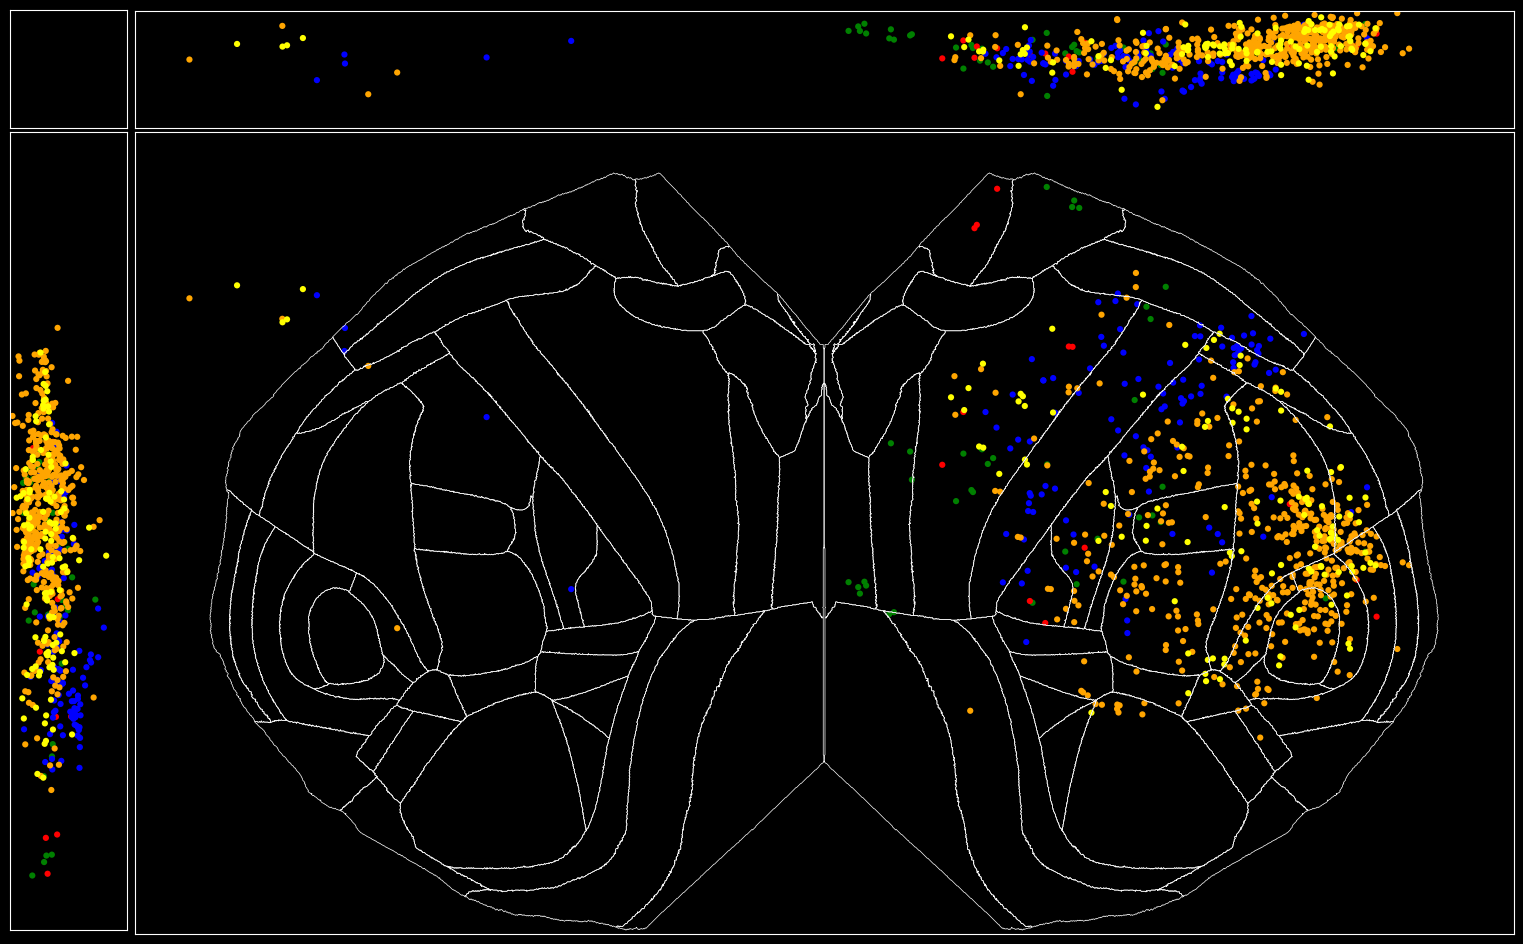

In [18]:
%%time
# morphological_list = morphological_dict["unnormalized"] # unnormalized, normalized_layers, normalized_full
# label_image = create_label_images(morphological_list)
# top_left_images = create_top_left_images(morphological_list)
# top_image = np.fliplr(top_left_images["top"])
# left_image = top_left_images["left"]

plt.style.use('dark_background')
label_cmap = ListedColormap(['black', 'green', 'red', 'blue', 'orange', 'yellow', 'purple', 'pink', 'cyan', 'brown', 'white'])

fig, axes = setup_main_plot()
axes = plot_boundaries(axes, bf_left_boundaries, bf_right_boundaries)
color_map_template = "Greys_r"
color_map = "Dark2_r"

marker_size = 20
main_shape = bf_projection_max_3d.max(axis=2).T.shape
top_shape = bf_projection_max_3d.max(axis=1).T.shape
left_shape = bf_projection_max_3d.max(axis=0).shape



# axes[1, 1].imshow(bf_projection_max.T, cmap=color_map_template, alpha=1.0, interpolation=None)
# plot our region boundaries
for k, boundary_coords in bf_left_boundaries.items():
    axes[1, 1].plot(*boundary_coords.T, c="white", lw=0.5)
for k, boundary_coords in bf_right_boundaries.items():
    axes[1, 1].plot(*boundary_coords.T, c="white", lw=0.5)

for i, points in enumerate(morphological_list):
    axes[1, 1].set_xlim(0, main_shape[1])
    axes[1, 1].set_ylim(main_shape[0], 0)
    # axes[1, 1].scatter(points[:, 0], points[:, 1], s=1, edgecolors='none', c='steelblue')
    # main plot
    axes[1, 1].scatter(points[:, 0], points[:, 1], s=marker_size, edgecolors='none', c=label_cmap.colors[i])
    # top plot
    axes[0, 1].scatter(points[:, 0], points[:, 2], s=marker_size, edgecolors='none', c=label_cmap.colors[i])
    axes[0, 1].set_xlim(0, top_shape[1])
    axes[0, 1].set_ylim(top_shape[0], 0)
    axes[0, 1].set(xticks=[], yticks=[], anchor="SW", aspect='equal')

    # Left plot
    axes[1, 0].scatter(points[:, 2], points[:, 1], s=marker_size, edgecolors='none', c=label_cmap.colors[i])
    axes[1, 0].set_xlim(0, left_shape[1])
    axes[1, 0].set_ylim(left_shape[0], 0)
    axes[1, 0].set(xticks=[], yticks=[], anchor="NE", aspect='equal')

axes[1, 1].invert_xaxis()
axes[1, 0].invert_yaxis()
axes[0, 1].invert_xaxis()

# axes[1, 1].invert_xaxis()


# ax = axes[1, 1].imshow(dilated_image, cmap=label_cmap, alpha=0.5, interpolation=None)

# axes[0, 1].imshow(top_image, cmap=label_cmap, alpha=1.0, interpolation=None)
# axes[1, 0].imshow(left_image, cmap=label_cmap, alpha=1.0, interpolation=None)